In [1]:
import time
import numpy as np                 # package for numerics
import pandas as pd                # package for data frames  
import matplotlib.pyplot as plt    # package for plotting     




from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Cross validations 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance

# Scores

from sklearn.metrics import mean_absolute_error as mae # Metric 
from sklearn.metrics import r2_score  as r2                 # Metric
from sklearn.metrics import mean_squared_error as mse  

# Optimisation 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Keras Model 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor


# Other Visual etc 
import seaborn as sns
from matplotlib.patches import Patch  # Thi is a function to generate plot 
from matplotlib import cm
np.random.seed(1338)

# Optimization

from pyswarm import pso  

Using TensorFlow backend.


# Import Data

In [2]:
df1= pd.read_csv("Data.csv", index_col='Datetime', parse_dates=True) 
df2= pd.read_csv("Data2020.csv", index_col='Datetime', parse_dates=True)
df = pd.concat([df1,df2 ])

In [3]:
# shift inputs if needed here !

In [4]:
features=df
features.insert(1,"SMeanT",df.MeanT-df.SetTemp)  # Insert Output
features.SMeanT=features.SMeanT.shift(-1)       # Shift output by 1 place !

In [5]:
# Put Windows to end
windows=['Win_AFT', 'Win_AFB','Win_ARoof', 'Win_Akip', 'Win_BFT', 'Win_BFB', 'Win_Broof', 'Win_BKip','Vfloor_A','Vfloor_B']
features = features[ [ col for col in features.columns if col not in windows ] + windows ]
Names=list(features.columns)
unwanted = { 'group', 'WindD','SMeanT', 'WindDc','hourC','hourS','Rain','SetTemp','Spa','MeanC','WindDC_nan','WindDs'}
Xnames = [e for e in Names if e not in unwanted]
features['group'] = (features.index -features.index[0]).days

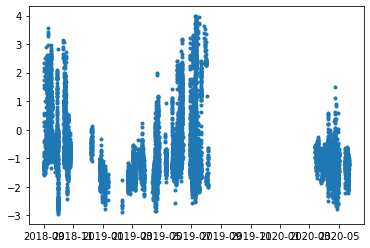

In [6]:
# Filter SMEANT 
features=features.loc[features.SMeanT.between(-3,4),:]
plt.plot(features.SMeanT,'.')

In [7]:
features=features.dropna(axis=0)

# Prapare Data 

In [8]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 40).split(features, groups=features['group']))

Train = features.iloc[train_inds]
Test = features.iloc[test_inds]

X = Train[Xnames].values
y = Train["SMeanT"].values  
print("X.shape:  ", X.shape)
print("y.shape:  ", y.shape)

X_test = Test[Xnames].values
y_test = Test["SMeanT"].values  
print("X.shape:  ", X_test.shape)
print("y.shape:  ", y_test.shape)

X.shape:   (9830, 19)
y.shape:   (9830,)
X.shape:   (3987, 19)
y.shape:   (3987,)


In [9]:
group=Train.group
n_splits=5
cv=GroupShuffleSplit(n_splits,random_state=24) 
ng=len(np.unique(features["group"].values))

# Hyperparameter Tuning

In [10]:
def create_model(neurons=1):
	# create model
	model = Sequential()
	model.add(Dense(neurons, input_dim=X.shape[1], activation='relu'))
	model.add(Dense(1))
	model.compile(optimizer='adam',loss='mean_squared_error' )
	return model


model =make_pipeline(StandardScaler(), KerasRegressor(build_fn=create_model, verbose=0))
# define the grid search parameters
batch_size = [5,10,20,40,80, 100]
neurons = [20, 30, 40, 50]
epochs = [5,10,20, 30,50, 60, 80, 100]
param_grid = dict(kerasregressor__neurons=neurons,kerasregressor__batch_size=batch_size, kerasregressor__epochs=epochs)


grid = RandomizedSearchCV(estimator=model,  param_distributions =param_grid, scoring= 'neg_mean_squared_error',cv = cv, n_iter =50,verbose=10, random_state=42, n_jobs = 1,iid=True)
grid_result = grid.fit(X, y,group)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10, score=-0.134, total=  18.6s
[CV] kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s remaining:    0.0s


[CV]  kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10, score=-0.101, total=  23.2s
[CV] kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.7s remaining:    0.0s


[CV]  kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10, score=-0.128, total=  18.5s
[CV] kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV]  kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10, score=-0.065, total=  17.3s
[CV] kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV]  kerasregressor__neurons=30, kerasregressor__epochs=30, kerasregressor__batch_size=10, score=-0.118, total=  21.0s
[CV] kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s


[CV]  kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80, score=-0.160, total=   1.9s
[CV] kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s


[CV]  kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80, score=-0.121, total=   2.0s
[CV] kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s


[CV]  kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80, score=-0.146, total=   2.4s
[CV] kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


[CV]  kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80, score=-0.070, total=   1.8s
[CV] kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.8min remaining:    0.0s


[CV]  kerasregressor__neurons=20, kerasregressor__epochs=20, kerasregressor__batch_size=80, score=-0.124, total=   1.6s
[CV] kerasregressor__neurons=20, kerasregressor__epochs=30, kerasregressor__batch_size=20 
[CV]  kerasregressor__neurons=20, kerasregressor__epochs=30, kerasregressor__batch_size=20, score=-0.138, total=   9.0s
[CV] kerasregressor__neurons=20, kerasregressor__epochs=30, kerasregressor__batch_size=20 
[CV]  kerasregressor__neurons=20, kerasregressor__epochs=30, kerasregressor__batch_size=20, score=-0.105, total=  11.5s
[CV] kerasregressor__neurons=20, kerasregressor__epochs=30, kerasregressor__batch_size=20 
[CV]  kerasregressor__neurons=20, kerasregressor__epochs=30, kerasregressor__batch_size=20, score=-0.150, total=   8.1s
[CV] kerasregressor__neurons=20, kerasregressor__epochs=30, kerasregressor__batch_size=20 
[CV]  kerasregressor__neurons=20, kerasregressor__epochs=30, kerasregressor__batch_size=20, score=-0.067, total=   7.9s
[CV] kerasregressor__neurons=20, ker

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 60.4min finished
C:\Users\au327049\Conda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best: -0.106067 using {'kerasregressor__neurons': 50, 'kerasregressor__epochs': 50, 'kerasregressor__batch_size': 5}
-0.109722 (0.025517) with: {'kerasregressor__neurons': 30, 'kerasregressor__epochs': 30, 'kerasregressor__batch_size': 10}
-0.124593 (0.031117) with: {'kerasregressor__neurons': 20, 'kerasregressor__epochs': 20, 'kerasregressor__batch_size': 80}
-0.116053 (0.029458) with: {'kerasregressor__neurons': 20, 'kerasregressor__epochs': 30, 'kerasregressor__batch_size': 20}
-0.117311 (0.029709) with: {'kerasregressor__neurons': 50, 'kerasregressor__epochs': 30, 'kerasregressor__batch_size': 80}
-0.110283 (0.024097) with: {'kerasregressor__neurons': 30, 'kerasregressor__epochs': 50, 'kerasregressor__batch_size': 40}
-0.112616 (0.025384) with: {'kerasregressor__neurons': 30, 'kerasregressor__epochs': 50, 'kerasregressor__batch_size': 100}
-0.117884 (0.024466) with: {'kerasregressor__neurons': 50, 'kerasregressor__epochs': 30, 'kerasregressor__batch_size': 5}
-0.111046 (0.027727) w

# ANN

# Purmutation Importance

In [16]:
import pickle
GP = pickle.load(open('GP_Model.sav', 'rb'))
GB=pickle.load(open('GB_Model.sav', 'rb'))
RF=pickle.load(open('RF_Model.sav', 'rb'))
SVM=pickle.load(open('SVM_Model.sav', 'rb'))

In [17]:
def create_model(neurons=30):
	# create model
	model = Sequential()
	model.add(Dense(neurons, input_dim=X.shape[1], activation='relu'))
	model.add(Dense(1))
	model.compile(optimizer='adam',loss='mean_squared_error' )
	return model


model =make_pipeline(StandardScaler(), KerasRegressor(build_fn=create_model, verbose=0, batch_size=100,epochs=80))
model.fit(X,y)
ANN=model

In [18]:
Xnames=['T_out',
 'MeanT',
 'MeanRH',
 'WindMag',
 'DayE',
 'DayW',
 'WindD_E',
 'WindD_P',
 'WindD_W',
 'Win_FTW',
 'Win_FBW',
 'Win_RoofW',
 'Win_KipW',
 'Win_FTE',
 'Win_FBE',
 'Win_RoofE',
 'Win_KipE',
 'VentW',
 'VentE']

In [19]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=7)
plt.rc('axes', labelsize=8)

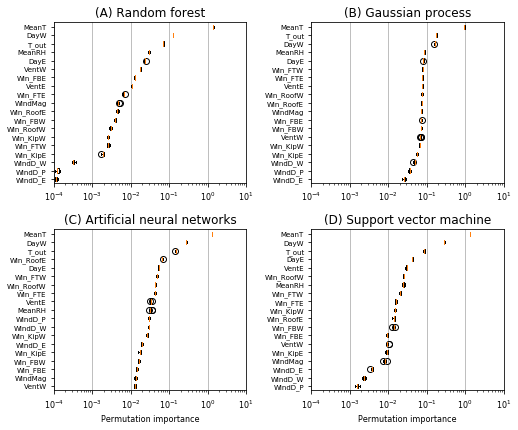

In [20]:
plt.figure(figsize=(7.3,7.3/1.2))

ax=plt.subplot(2,2,1)
feature_names = np.r_[Xnames]
result = permutation_importance(RF, X, y, n_repeats=20,
                               random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T, vert=False)
ax.set_xscale("log")
ax.set_yticklabels(labels=feature_names[sorted_idx], minor=False)
plt.tight_layout()
ax.set_xlim([0.0001, 10])
#ax.set_xlabel('Feature importance')
ax.set_title('(A) Random forest')
ax.grid(axis='x')

ax=plt.subplot(2,2,2)
feature_names = np.r_[Xnames]
result = permutation_importance(GP, X, y, n_repeats=20,
                               random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T, vert=False)
ax.set_yticklabels(labels=feature_names[sorted_idx], minor=False)
ax.set_xscale("log")
plt.tight_layout()
ax.set_xlim([0.0001, 10])
#ax.set_xlabel('Feature importance')
ax.set_title('(B) Gaussian process')
ax.grid(axis='x')

ax=plt.subplot(2,2,3)
feature_names = np.r_[Xnames]
result = permutation_importance(ANN, X, y, n_repeats=20,
                               random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T, vert=False)
ax.set_yticklabels(labels=feature_names[sorted_idx], minor=False)
ax.set_xscale("log")
plt.tight_layout()
ax.set_xlim([0.0001, 10])
ax.set_xlabel('Permutation importance')
ax.set_title('(C) Artificial neural networks')
ax.grid(axis='x')



ax=plt.subplot(2,2,4)
feature_names = np.r_[Xnames]
result = permutation_importance(SVM, X, y, n_repeats=20,
                               random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T, vert=False)
ax.set_yticklabels(labels=feature_names[sorted_idx], minor=False)
ax.set_xscale("log")
plt.tight_layout()
ax.set_xlim([0.0001, 10])
ax.set_xlabel('Permutation importance')
ax.set_title('(D) Support vector machine')
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('Pimp.png',dpi=600)
#plt.show()  